## Process the geocoded ALOS-2 PALSAR-2 data for use within the statistical analysis

#### Uses the netcdf outputs from the SNAP/Snappy processing. Previous post-processing steps applied:
- Coregistration of images to form a stack for each track/row number.
- Single images speckle correction (Improved Lee Sigma speckle filter, sigma=0.9, sampling window = 7x7, target window = 3x3, resampling = nearest neighbour)
- Geocoding and resampling from 25 to 100m resolution (bilinear resampling)

#### Outputs from this code:
##### Section 1 - ALOS data formatting and statistics:
- HH and HV expressed in decibels 
- derived indicators: HHHV ratio, RVI
- statistics for HH, HV, HHHV ratio, RVI: min, max, standard dev, range

##### Section 2 - Quickstart option:
- reformatted ALOS data (reversal of the lat dimension order, extraction of only the 'db' variable)
- net water daily 1km data regridded to the same grid as the ALOS data

##### Section 3 - Regridding of the overlapping images to the same as the area2 stack of daily data
- inputs: daily HH - remake this using the interpolate_HH_to_daily.ipynb, and the overlapping images
- method: cutout the overlapping regions (max/min lat and lon range) and then regrid the overlapping images to the main stack. 
- outputs: a netcdf file for each overlapping image area - stats will later be calculated on this. 




In [1]:
# %load 'imports.py'
# imports required for flood mapping code

import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
from scipy import stats

# set plotting parameters
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Important to set this environment variable so that netcdf files can be opened.
%env HDF5_USE_FILE_LOCKING=FALSE

### Declare data and output directories here

env: HDF5_USE_FILE_LOCKING=FALSE


### Functions

In [2]:
def norm_to_zero_one(da):
    # a function to normalise xarray data between 0 and 1
    da_new = da.copy()
    for i in range(len(da)):     
        da_new[i] = da[i] - da[i].min() * 1.0 / (da[i].max() - da[i].min())
    return (da_new)

### Section 1 - ALOS data formatting and statistics

#### 1. lists of the dates corresponding with each area of stacked images

In [3]:
# array of alos2 scene dates within each area
total_areas = 5

area1 = ['2021-11-24']
area2 = ['2019-03-29','2019-05-10','2019-06-21','2019-07-19','2019-08-30','2019-10-11','2019-11-22','2020-01-03','2020-02-14','2020-03-27','2020-05-08','2020-06-19','2020-07-17','2020-08-28','2020-10-09','2021-10-08','2021-11-19']
area3 = ['2020-09-06','2020-10-18','2020-11-29','2021-09-05','2021-10-17']
area4 = ['2020-08-28','2020-10-09','2021-10-08','2021-11-19']
area5 = ['2020-09-06','2020-10-18','2020-11-29','2021-09-05','2021-10-17','2021-11-28']

# declaring an array of lists of dates
all_dates = [area1, area2, area3, area4, area5]

# converting to the datetime format required for dataframes
for i in range(len(all_dates)):
    all_dates[i] = pd.to_datetime(all_dates[i])

In [5]:
# reading in ALOS HH and HV for all areas
hh = []
hv = []

for i in range(total_areas):
    hh.append(xr.open_dataset(ALOS_new + 'Geocoded_HH_area' + str(i+1) + '_corrected.nc'))
    hv.append(xr.open_dataset(ALOS_new + 'Geocoded_HV_area' + str(i+1) + '_corrected.nc'))


In [ ]:
%%time
# concatenating the bands within each stack of images along the time dimension
HH = []
HV = []

for i in range(total_areas):
    print (i)
    HH.append(hh[i].to_array("time", name="Amplitude").to_dataset().assign_coords(time=all_dates[i]))
    HV.append(hv[i].to_array("time", name="Amplitude").to_dataset().assign_coords(time=all_dates[i]))

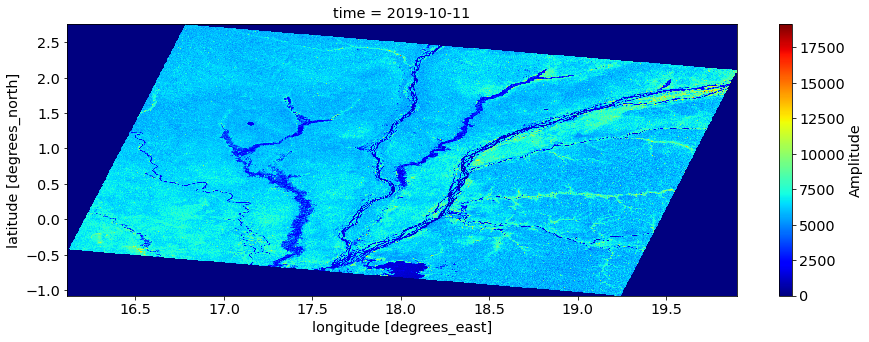

In [9]:
HH[1]['Amplitude'][5][::5,::5].plot()

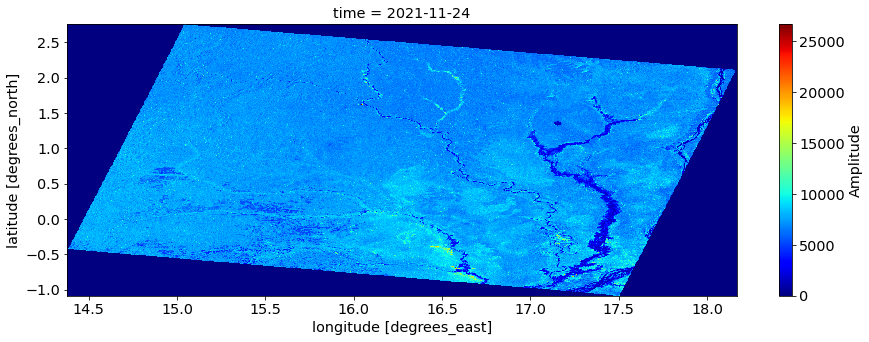

In [8]:
HH[0]['Amplitude'][0][::5,::5].plot(vmin=0)

### Calculating derived SAR indices and converting outputs to decibels

In [ ]:
%%time

# Declaring arrays for the derived indices for each set of stacked scenes
RVI = []
HHHV_ratio = []
calibration_factor = -83

for i in range(total_areas):
    HH[i]['Intensity']=HH[i]['Amplitude']**2
    HV[i]['Intensity']=HV[i]['Amplitude']**2
    

    # radar vegetation index formula for dual pol
    # see: https://rua.ua.es/dspace/bitstream/10045/108088/2/Mandal_etal_2020_RemoteSensEnviron_preprint.pdf
    # and Trudel et al. 2012 - specific to HH, HV: 4HV/(HH+HV) - all sigma naught in power units, 
    # so apply to intensity values
    # Could this be used for vegetation type classification?

    RVI.append(4*HV[i]['Intensity']/(HH[i]['Intensity']+HV[i]['Intensity']))
    
    # calibration factor for the PALSAR-2 instrument
    calibration_factor = -83
    
    # Conversion from digital number to decibels
    HH[i]['db'] = 10*np.log10(HH[i]['Intensity']) + calibration_factor
    HV[i]['db'] = 10*np.log10(HV[i]['Intensity']) + calibration_factor
    HHHV_ratio.append(HH[i]['db'] - HV[i]['db'])
    
    # to calculate RVI from the new 'db' geocoded data, convert back to intensity first - reverted to original method
    # so no longer necessary to do it this way


In [ ]:
# Check that the output is the digital number (and not normalised)
# the normalisation setting is a default option in SNAP, and needs to be unset
for i in range(total_areas):
    print (HH[i]['db'][0].max())

In [ ]:
# Saving ALOS data to netcdf for each stack of scenes
for i in range(total_areas):
    print ("Saving for area " + str(i+1))
    HH[i].to_netcdf(path=ALOS_OUT + 'ALOS_HH_area' + str(i+1) + '.nc')
    HV[i].to_netcdf(path=ALOS_OUT + 'ALOS_HV_area' + str(i+1) + '.nc')
    HHHV_ratio[i].to_netcdf(path=ALOS_OUT + 'ALOS_HHHV_ratio_area' + str(i+1) + '.nc')
    RVI[i].to_netcdf(path=ALOS_OUT + 'ALOS_RVI_area' + str(i+1) + '.nc')
    #RVI_norm[i].to_netcdf(path=ALOS_OUT + 'ALOS_RVI_normalised_area' + str(i+1) + '.nc')

In [ ]:
# comparing with the land type map for the same extents
# cutting out the land-type map to the extents of the ALOS data
WRKDIR2 = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/'
land_type = xr.open_rasterio(WRKDIR2 + 'Veg_maps/Crezee_2022_Smoothed_7x7_Classification_Most_likely_class.tif')

lt = land_type.rename({'x':'lon','y':'lat'})
lt = lt[0].to_dataset(name='type')

# reversing lat values
lt = lt.reindex(lat=lt.lat[::-1])

min_lat = hh_norm['lat'].min()
max_lat = hh_norm['lat'].max()
min_lon = hh_norm['lon'].min()
max_lon = hh_norm['lon'].max()

print(min_lat, max_lat,min_lon, max_lon)

lt_sub = lt['type'].sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon))
lt_sub = lt_sub.to_dataset(name='type')
lt_sub = lt_sub.where(lt_sub['type'].isin([4,5]))
lt_sub['type'][::5,::5].plot(vmin=0)


### Calculating stats for each indicator across each stack

In [20]:
# calculating min, max, range and stdev across each area's image stack
# copying just one time step to create a new xarray dataset with the same lat lon dims

HH_stats = []
for i in range(total_areas):
    HH_stats.append(HH[i]['db'][0].copy(deep=True,data=None).drop('time'))
    HH_stats[i]['stdev'] = HH[i]['db'].std(dim='time')
    HH_stats[i]['min'] = HH[i]['db'].min(dim='time')
    HH_stats[i]['max'] = HH[i]['db'].max(dim='time')
    HH_stats[i]['range'] = HH_stats[i]['max']-HH_stats[i]['min']

    # saving to netcdf
    HH_stats[i].to_netcdf(path=ALOS_OUT + 'ALOS_HH_area' + str(i+1) + '_stats.nc')

In [21]:
# Repeating for HV stats

HV_stats = []
for i in range(total_areas):
    HV_stats.append(HV[i]['db'][0].copy(deep = True,data=None).drop('time'))
    HV_stats[i]['stdev'] = HV[i]['db'].std(dim ='time')
    HV_stats[i]['min'] = HV[i]['db'].min(dim ='time')
    HV_stats[i]['max'] = HV[i]['db'].max(dim ='time')
    HV_stats[i]['range'] = HV_stats[i]['max'] - HV_stats[i]['min']

    # saving to netcdf
    HV_stats[i].to_netcdf(path = ALOS_OUT + 'ALOS_HV_area' + str(i+1) + '_stats.nc')

In [22]:
# Repeating for HHHV ratio stats

HHHV_ratio_stats = []
for i in range(total_areas):
    HHHV_ratio_stats.append(HHHV_ratio[i][0].copy(deep = True,data=None).drop('time'))
    HHHV_ratio_stats[i]['stdev'] = HHHV_ratio[i].std(dim ='time')
    HHHV_ratio_stats[i]['min'] = HHHV_ratio[i].min(dim ='time')
    HHHV_ratio_stats[i]['max'] = HHHV_ratio[i].max(dim ='time')
    HHHV_ratio_stats[i]['range'] = HHHV_ratio_stats[i]['max'] - HV_stats[i]['min']

    # saving to netcdf
    HHHV_ratio_stats[i].to_netcdf(path = ALOS_OUT + 'ALOS_HHHV_ratio_area' + str(i+1) + '_stats.nc')

In [23]:
# Repeating for RVI stats - TRY later with RVI normalised

RVI_stats = []
for i in range(total_areas):
    RVI_stats.append(RVI[i][0].copy(deep = True,data=None).drop('time'))
    RVI_stats[i]['stdev'] = RVI[i].std(dim ='time')
    RVI_stats[i]['min'] = RVI[i].min(dim ='time')
    RVI_stats[i]['max'] = RVI[i].max(dim ='time')
    RVI_stats[i]['range'] = RVI_stats[i]['max'] - RVI_stats[i]['min']

    # saving to netcdf
    RVI_stats[i].to_netcdf(path = ALOS_OUT + 'ALOS_RVI_area' + str(i+1) + '_stats.nc')

### Section 2: QUICK START
#### Reformatting the ALOS data for use within the flood mapping code, and regridding the net water data to match it 
- previously these steps were done within Pixelwise_correlation.ipynb
- first, quickstart, reading in the files produced above

In [38]:
# Reading in the ALOS area data that was output earlier in this code
total_areas = 5 
HH = []
HV = []
HHHV = []
#RVI = []

for i in range(total_areas):
    HH.append(xr.open_dataset(ALOS_OUT + 'ALOS_HH_area' + str(i+1) + '.nc'))
    HV.append(xr.open_dataset(ALOS_OUT + 'ALOS_HV_area' + str(i+1) + '.nc'))
    HHHV.append(xr.open_dataset(ALOS_OUT + 'ALOS_HHHV_ratio_area' + str(i+1) + '.nc'))
    RVI.append(xr.open_dataset(ALOS_OUT + 'ALOS_RVI_area' + str(i+1) + '.nc'))

# reading in the net water data
nw_daily = xr.open_dataset(ALOS_OUT + '../ALOS_nc2/nw_daily.nc')


In [ ]:
# changing the net water variable name, and creating a subset of times for the regridding
var_name = list(nw_daily.keys())

# using the subset required for our study area (this reduces the number of images by half 
# - too many images were resulting in the regridding code crashing before, so may need to run it on subsets and 
# join them together later on if expanding the time range of this study in the future.)
nw_subset = nw_daily.loc[dict(time=slice("2019-03-29","2021-11-19"))]
ds = nw_subset.rename({var_name[0]:'net water'})
ds

In [41]:
%%time
# interpolating the net water data set to the same grid as the HH area2 data
HH_db = HH[1]['db'][0]
HH_db

# only run this method once - it takes a long time, read in outputs in quickstart below
print ("Regridding net water to HH grid...")
nw_new = ds['net water'].interp_like(HH_db,method='nearest')

# reversing the lat index (currently from high to low)
nw_new = nw_new.reindex(lat=nw_new.lat[::-1])

print ("Saving...")
# saving - also takes a long time to save as it's a very large daily file at 100m resolution 
nw_new.to_netcdf(path=ALOS_OUT + 'nw_daily_new_100m.nc')
print ("Completed.")

Regridding net water to HH grid...
Saving...
Completed.
CPU times: user 4min 58s, sys: 24min 1s, total: 28min 59s
Wall time: 30min 26s


In [ ]:
#### QUICKSTART with net water data
nw = xr.open_dataset(ALOS_OUT + 'nw_daily_new_100m.nc')

# reversing the lat index (currently from high to low)
# - this is now done within the above step
#nw = nw.reindex(lat=nw.lat[::-1])
#nw.to_netcdf(path=ALOS_OUT + 'nw_daily_new_100m.nc')
nw

In [49]:
## reformatting the ALOS data - 'db' dimension only, and reversing the lat dimension to be in the order low to high
HH[0]['db']

HH_new = []
HV_new = []
HHHV_new = []
RVI_new = []

for i in range(total_areas):
    #RVI[i]  = RVI[i].to_dataset(name='RVI')
    HH_new.append(HH[i]['db'])
    HV_new.append(HV[i]['db'])
    HHHV_new.append(HHHV[i]['db'])
    #RVI_new.append(RVI[i]['Intensity'])
    
    # reversing the lat dimension coordinates
    HH_new[i] = HH_new[i].reindex(lat=HH_new[i].lat[::-1])
    HV_new[i] = HV_new[i].reindex(lat=HV_new[i].lat[::-1])
    HHHV_new[i] = HHHV_new[i].reindex(lat=HHHV_new[i].lat[::-1])
    #RVI_new[i] = RVI_new[i].reindex(lat=RVI_new[i].lat[::-1])
    
    # saving to new files for use in the flood mapping code and comparison with water table depths code
    HH_new[i].to_netcdf(path=ALOS_OUT + 'HH_db_100m_area' + str(i+1) + '.nc')
    HV_new[i].to_netcdf(path=ALOS_OUT + 'HV_db_100m_area' + str(i+1) + '.nc')
    HHHV_new[i].to_netcdf(path=ALOS_OUT + 'HHHV_db_100m_area' + str(i+1) + '.nc')
    #RVI_new[i].to_netcdf(path=ALOS_OUT + 'RVI_db_100m_area' + str(i+1) + '.nc')


### Next code: Calculate_PW_correlations.ipynb